# Simple regression model

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [5]:
ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data('./data/weather_collections/weather_daily_region.csv')

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 


### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [6]:
#explore_clusters(gs_agg[['x', 'y']])

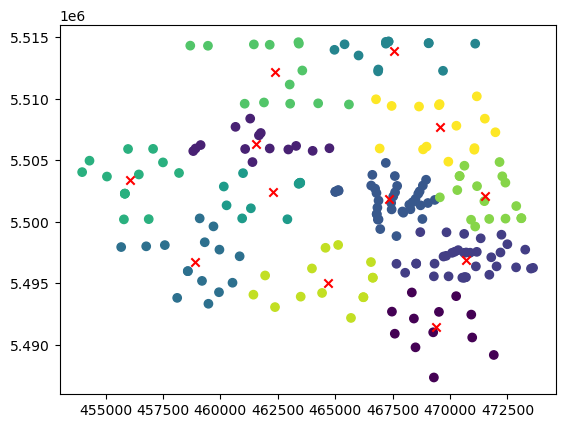

In [7]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

plot_clusters(gs_agg[['x', 'y']], labels, centers)

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

### Merge data

In [8]:
g_merged = merge_groundwater_data(g, gs_agg)
#g_merged.describe()

In [9]:
#g_merged.head()

In [10]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

# restrict data to the post-war period
m = m.loc[m.date > pd.to_datetime('1950-01-01')]

# drop all rows with a date after the weather data cutoff date
m = m.loc[m.date <= pd.to_datetime('2022-12-31')]

m = m.dropna(subset=['station_id_count'])

m['week_of_year'] = m['date'].dt.isocalendar().week

In [11]:
#m.info()

In [12]:
#m.describe()

## Train-test split

In [13]:
m.columns.unique()

Index(['station_id', 'date', 'water_dist', 'water_level', 'water_depth',
       'water_temp', 'x', 'y', 'start_date', 'end_date', 'ground_elev',
       'measure_elev', 'lifespan', 'geometry', 'water_level_mean',
       'water_depth_mean', 'water_temp_mean', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'reg_clusters', 'water_depth_anomaly',
       'station_id_count', 'precip_mean', 'precip_min', 'precip_max',
       'precip_std', 'tmean_mean', 'tmean_min', 'tmean_max', 'tmean_std',
       'tmax_mean', 'tmax_min', 'tmax_max', 'tmax_std', 'tmin_mean',
       'tmin_min', 'tmin_max', 'tmin_std', 'moisture_mean', 'moisture_min',
       'moisture_max', 'moisture_std', 'precip_mean_prev_2d_sum',
       'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'precip_mean_prev_1y_sum',
       'precip_mean_prev_3y_sum', 'tmean_mean_prev_2d_mean',
       'tmean_mean_prev_7d_mean'

In [14]:
# restrict data to these columns
df = m[['station_id',
        'date',
        'water_depth',
        'ground_elev',
        'x', 'y',
        'geometry',
        'reg_clusters',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_2d_sum',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'precip_mean_prev_1y_sum',
        'precip_mean_prev_3y_sum',
        'tmean_mean_prev_2d_mean',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean',
        'tmean_mean_prev_1y_mean',
        'tmean_mean_prev_3y_mean'
       ]]
#df.info()

In [15]:
#df[df.isna().any(axis=1)]

In [16]:
df = df.dropna()

In [17]:
train, test, X_train, X_test, y_train, y_test, info_train, info_test = tt_split_by_stations(df)


In [18]:
train

,station_id,date,ground_elev,x,y,geometry,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,13491,1950-01-02,89.77,461330.000,5501099.000,POINT (8.46418 49.66119),6,1.375745,0.218806,0.85,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,13492,1950-01-02,90.30,460271.000,5501339.000,POINT (8.44948 49.66328),6,2.165060,0.232807,1.65,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,13518,1950-01-02,96.27,468337.000,5494261.000,POINT (8.56182 49.60009),0,1.996575,0.303054,1.15,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,12896,1950-01-02,88.70,462150.000,5505957.000,POINT (8.47507 49.70493),1,1.037206,0.252420,0.68,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,14082,1950-01-02,92.37,461440.000,5494081.000,POINT (8.46639 49.59807),10,3.634884,0.216650,3.09,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,13544,2022-12-31,95.89,470586.000,5495471.000,POINT (8.59285 49.61109),2,1.647645,0.344207,0.63,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,13832,2022-12-31,93.71,470626.000,5504557.000,POINT (8.59272 49.69282),9,2.002682,0.277334,0.96,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,12909,2022-12-31,88.02,461900.003,5509695.241,POINT (8.47124 49.73854),8,2.348725,0.608354,0.82,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411


In [19]:
X_train

,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,precip_mean,tmean_mean,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,89.77,461330.000,5501099.000,6,1.375745,0.218806,0.85,2.03,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,90.30,460271.000,5501339.000,6,2.165060,0.232807,1.65,2.53,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,96.27,468337.000,5494261.000,0,1.996575,0.303054,1.15,2.48,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,88.70,462150.000,5505957.000,1,1.037206,0.252420,0.68,1.39,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,92.37,461440.000,5494081.000,10,3.634884,0.216650,3.09,4.00,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,95.89,470586.000,5495471.000,2,1.647645,0.344207,0.63,2.26,0.000,15.075,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,93.71,470626.000,5504557.000,9,2.002682,0.277334,0.96,2.56,0.000,15.075,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,88.02,461900.003,5509695.241,8,2.348725,0.608354,0.82,3.67,0.000,15.075,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411


In [20]:
#X_train.info()
#y_test.info()

## Create intuitive dummy model

As baseline, we can assume that water_depth is proportional to temp.

In [21]:
def dummy_model(t):
    return 0.05 * t + 2

dummy_model(10)

2.5

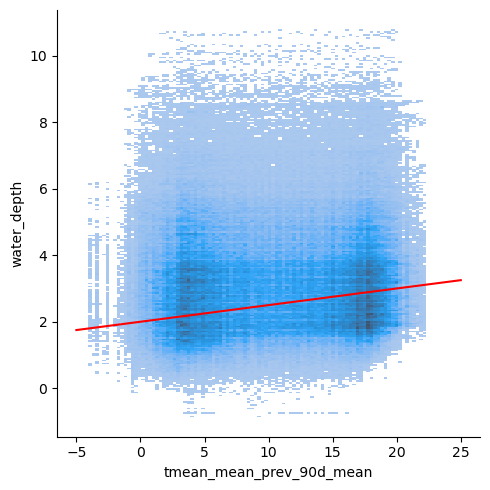

In [22]:
m_plot = m[['tmean_mean_prev_90d_mean', 'water_depth']].reset_index()
m_plot

sns.displot(data=m_plot, x='tmean_mean_prev_90d_mean', y='water_depth')
            
# works but is very slow (takes 10 minutes)
#sns.kdeplot(data=m_plot, 
#            x='tmean_mean_prev_30d_mean', y='water_depth',
               #alpha=0.01
#           )

x1, x2 = -5, 25
plt.plot([x1, x2],[dummy_model(x1), dummy_model(x2)], 'r');
            

In [23]:
# test dummy model
dummy_y_test_pred = dummy_model(X_test['tmean_mean_prev_90d_mean'])
dummy_y_test_pred

date
1950-01-02    2.326243
1950-01-02    2.326243
1950-01-02    2.326243
1950-01-08    2.294493
1950-01-09    2.288167
                ...   
2022-12-31    2.413431
2022-12-31    2.413431
2022-12-31    2.413431
2022-12-31    2.413431
2022-12-31    2.413431
Name: tmean_mean_prev_90d_mean, Length: 113368, dtype: float64

In [24]:
calc_metrics(y_test, dummy_y_test_pred)

MAE 1.1453100193531685
RMSE 1.6149688148634307
MAPE 0.44917685939398594
R2 -0.1548702647368203


{'MAE': 1.1453100193531685,
 'RMSE': 1.6149688148634307,
 'MAPE': 0.44917685939398594,
 'R2': -0.1548702647368203}

In [25]:
residuals = calc_residuals(y_test, dummy_y_test_pred)

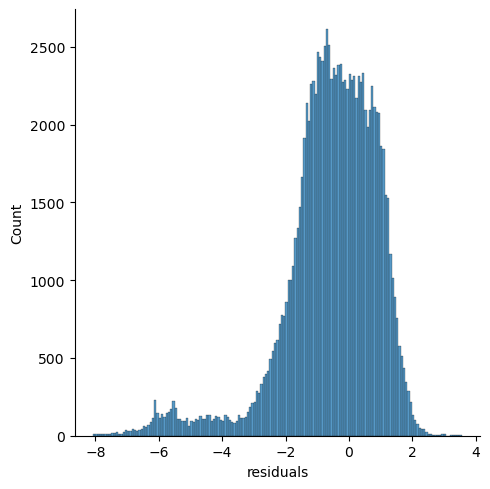

In [26]:
sns.displot(residuals['residuals'])

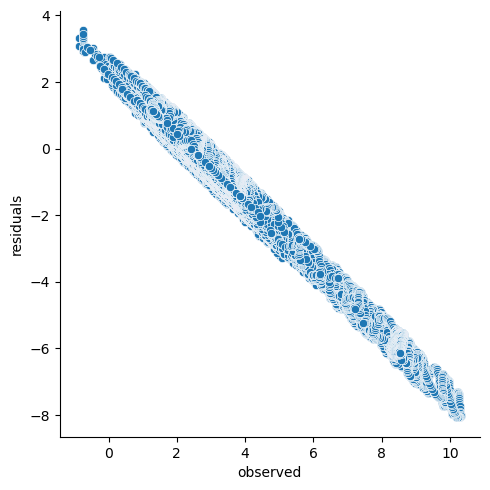

In [27]:
sns.relplot(data=residuals, x='observed', y='residuals')

## Exploratory PCA

In [28]:
pca, X_pca, pca_stats = perform_pca(X_train, 6)

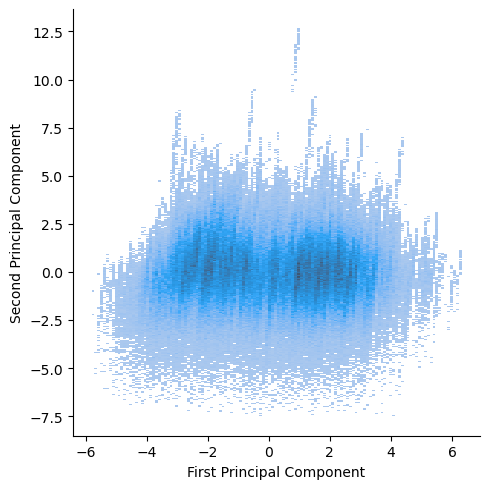

In [29]:
sns.displot(data=X_pca, x='pca0', y='pca1')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [30]:
pca_stats

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
Explained Variance Ratio,0.201634,0.136026,0.129548,0.100618,0.089106,0.062410
ground_elev,0.004787,-0.020153,0.065580,-0.616213,0.126701,-0.001691
x,0.006445,0.079521,-0.062710,-0.489765,0.146458,-0.017618
y,-0.003541,0.005941,-0.036825,0.448038,-0.099406,0.034801
reg_clusters,-0.008854,-0.130354,0.127107,0.256802,-0.098090,0.050590
ini_years_water_depth_mean,-0.022727,-0.375326,0.416986,-0.050626,-0.086636,0.043371
ini_years_water_depth_std,-0.013064,-0.093579,0.075986,0.203480,-0.029626,-0.076568
ini_years_water_depth_min,-0.018931,-0.346735,0.393997,-0.137682,-0.069136,0.065374
ini_years_water_depth_max,-0.023710,-0.375242,0.412677,-0.009570,-0.091419,0.032312
precip_mean,0.002300,0.251559,0.272571,0.079544,0.297066,0.297108


## Build initial pipelines

### Define preprocessing steps

In [31]:
#X_train.info()

In [32]:
# select categorical and numerical column names
#X_cat_columns = X_train.select_dtypes(exclude="number").columns
X_cat_columns = X_train.select_dtypes(include="int32").columns
X_num_columns = X_train.select_dtypes(include="float64").columns

# create numerical pipeline
num_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='mean')), # probably not needed...
           #('num_scaler', MinMaxScaler())
           ('num_scaler', StandardScaler())
          ])

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = Pipeline(
    steps=[#('cat_imputer', SimpleImputer(strategy='constant', fill_value='na')), 
           ('cat_encoder', OneHotEncoder(drop='first', 
                                         sparse_output=False, 
                                         handle_unknown='ignore'))
           #('cat_encoder', OrdinalEncoder())
          ])

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, X_num_columns), 
        ('cat', categoric_pipe, X_cat_columns)
    ],
    #remainder='passthrough'
).set_output(transform='pandas')

In [34]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  StandardScaler())]),
                                 Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_2d_sum', 'precip_mean_prev_...
       'precip_mean_prev_1y_sum', 'precip_mean_prev_3y_sum',
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['reg_clusters'], dtype='object'))])

### Define regressors to test

In [35]:
regressors = [
    #('DecisionTree', DecisionTreeRegressor()), # not really good
    ('SGD', SGDRegressor()),
    ('LinReg', LinearRegression()),
    #('PLS', PLSRegression()),
    #('RandForest', RandomForestRegressor(n_estimators=30)), # best so far but costly (>10 min)
    ('HGBoost', HistGradientBoostingRegressor()), # excellent and very fast
    #('GBR', GradientBoostingRegressor()), # rel. slow and inferior to HGBR
    #('AdaBoost', AdaBoostRegressor()), # so far not good
    #('SVR' , SVR()), # extremely slow
    #('' ,()),
    #('' ,()),
    # try XGBoost
]

### Create a pipeline for each classifier

In [36]:
pipelines = {}
for name, reg in regressors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('selector', SelectKBest(score_func=f_regression)),
        #('selector', RFECV(estimator=DecisionTreeRegressor())),
        #('feature_selection', SelectFromModel(DecisionTreeRegressor())),
        ('regressor', reg)
     ]).set_output(transform="pandas")
    pipelines[name] = pipeline


In [37]:
pipelines['LinReg']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean...
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['reg_clusters'], dtype='object'))])),
                ('regressor', LinearRegression())])

## Inspect models

more or less stats from dummy model: 

MAE 1.180524150300254

RMSE 1.5993132760325228

MAPE 495545893932.64526

R2 -0.3085209566128313

In [38]:
predictions = {}
metrics = {}
residuals = {}

for name in pipelines:
    print(name)
    pipe = pipelines[name]

    #print('FITTING')
    pipe.fit(X_train, y_train)
    print('--- train data ---')
    calc_metrics(y_train, pipe.predict(X_train))

    #print('PREDICTING')
    y_pred = pipe.predict(X_test)

    # save
    print('--- test data ---')
    predictions[name] = y_pred
    metrics[name] = calc_metrics(y_test, y_pred)
    residuals[name] = calc_residuals(y_test, y_pred)

SGD
--- train data ---
MAE 0.5833518888533235
RMSE 0.7866089998115366
MAPE 98520680868.1959
R2 0.7121725593223474
--- test data ---
MAE 0.5678025182747511
RMSE 0.7571562730527817
MAPE 0.2755509336310434
R2 0.7461507012133581
LinReg
--- train data ---
MAE 0.5834765841423625
RMSE 0.7855020431849584
MAPE 99890704625.24535
R2 0.7129820804666647
--- test data ---
MAE 0.5671469858086771
RMSE 0.7563328207088572
MAPE 0.27817955278201784
R2 0.7467025532939453
HGBoost
--- train data ---
MAE 0.29070763291737656
RMSE 0.4193700735746758
MAPE 44834670044.41568
R2 0.9181894625695591
--- test data ---
MAE 0.5361001181803811
RMSE 0.7084562909486539
MAPE 0.23129209361269898
R2 0.7777554905143401


In [39]:
#residuals['DecisionTree']

In [40]:
compare_models = pd.DataFrame(metrics)
compare_models

,SGD,LinReg,HGBoost
MAE,0.567803,0.567147,0.536100
RMSE,0.757156,0.756333,0.708456
MAPE,0.275551,0.278180,0.231292
R2,0.746151,0.746703,0.777755


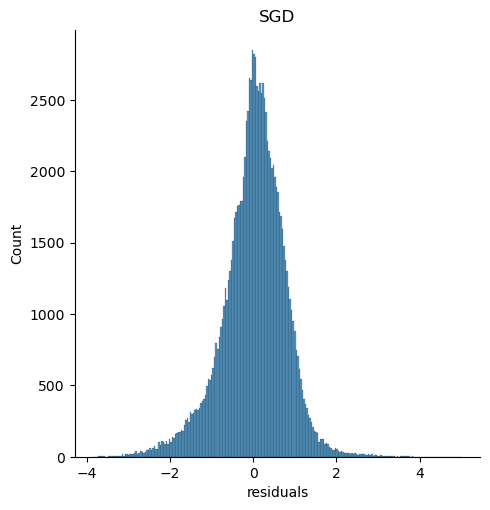

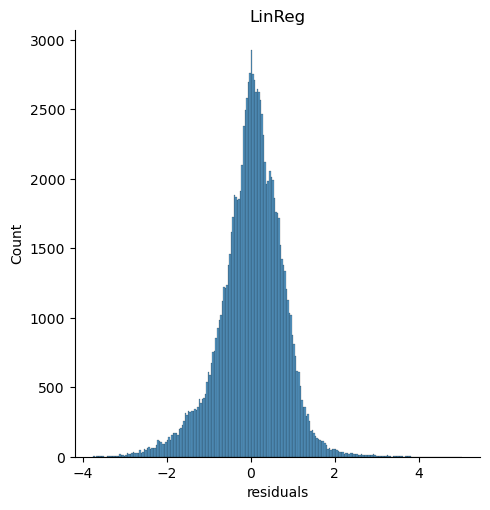

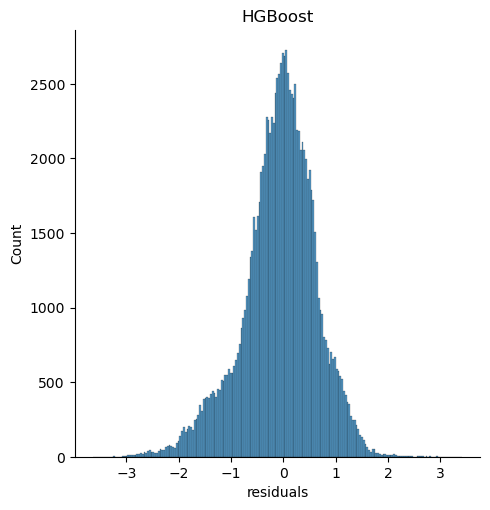

In [41]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

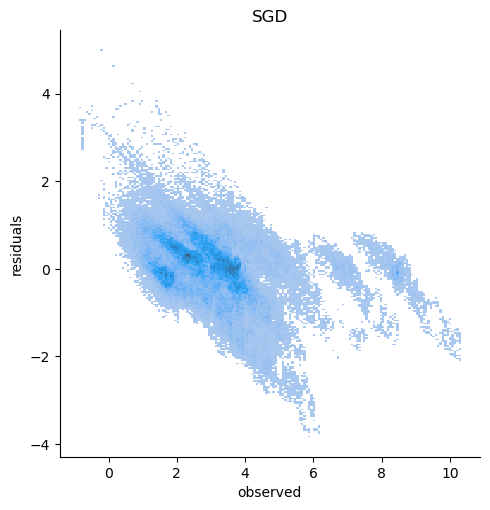

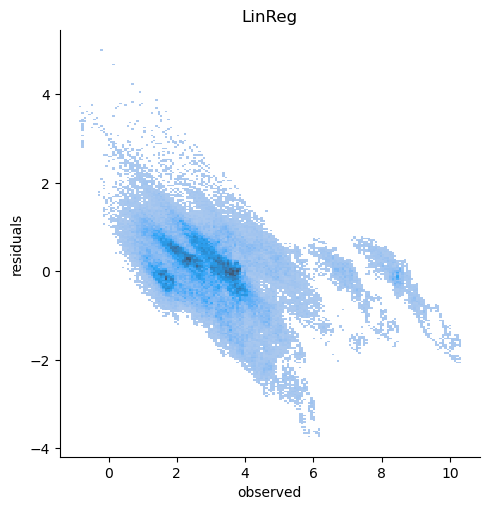

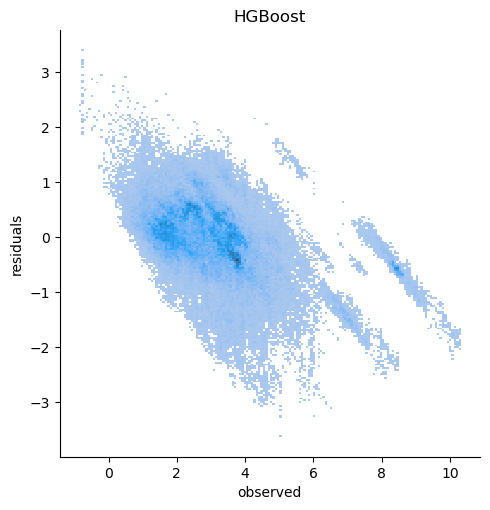

In [42]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

In [43]:
#residuals['HGBoost']

In [51]:
model = 'HGBoost'
y_pred = predictions[model]
resid = residuals[model]

y_pred = pd.DataFrame(y_pred, columns=['pred_water_depth'])
y_pred.index = info_test.index
#y_pred

In [52]:
test = pd.concat([info_test, X_test, y_test, y_pred, resid['residuals']],
                 axis='columns')

In [53]:
#test.info()

In [54]:
#test.describe()

In [55]:
test.head()

,station_id,date,geometry,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,water_depth,pred_water_depth,residuals
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,14166,1950-01-02,POINT (8.56323 49.58104),95.85,468427.000,5492142.000,0,0.464138,0.276676,-0.10,...,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059,1.74,2.010416,0.270416
1950-01-02,13813,1950-01-02,POINT (8.56967 49.68249),93.31,468957.000,5503418.000,3,1.296905,0.296586,0.68,...,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059,1.73,2.175617,0.445617
1950-01-02,12902,1950-01-02,POINT (8.45423 49.72066),87.63,460660.483,5507716.036,1,2.117403,0.498628,1.03,...,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059,3.03,2.502059,-0.527941
1950-01-08,13813,1950-01-08,POINT (8.56967 49.68249),93.31,468957.000,5503418.000,3,1.296905,0.296586,0.68,...,1749.544286,3.0000,3.542857,3.314167,5.889861,11.044075,10.810000,1.61,2.132374,0.522374
1950-01-09,14166,1950-01-09,POINT (8.56323 49.58104),95.85,468427.000,5492142.000,0,0.464138,0.276676,-0.10,...,1749.206786,0.9750,3.633929,3.310000,5.763333,11.041781,10.809623,1.69,1.977772,0.287772


In [56]:
test.station_id.unique()[0]

14166

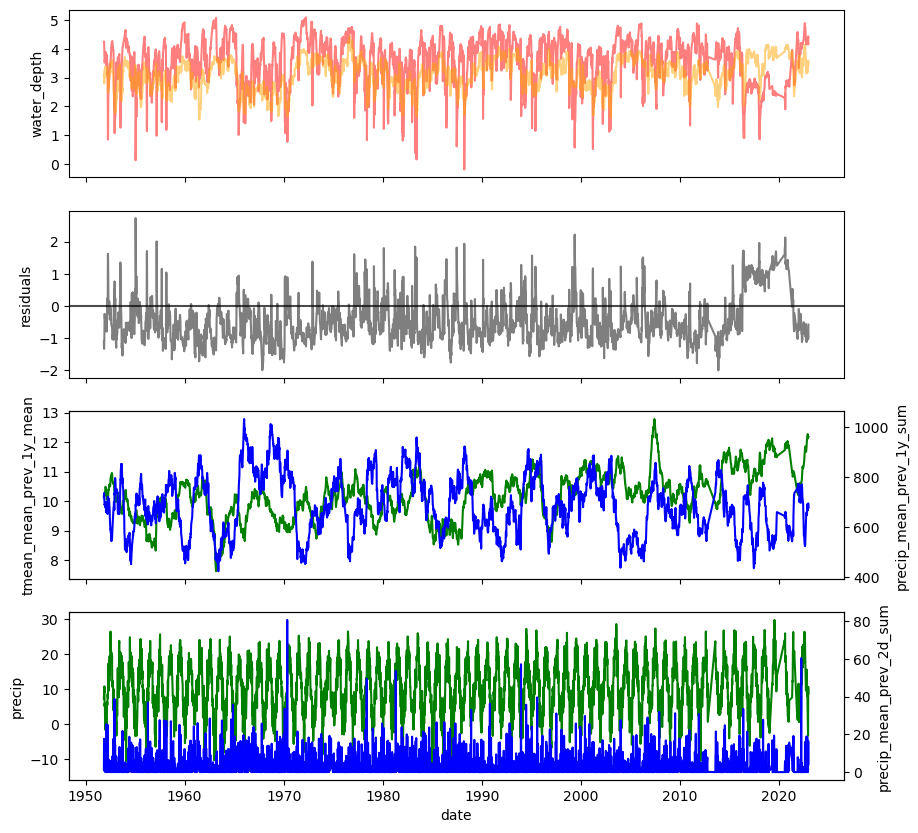

In [57]:
#data = test.loc[test.station_id == 13500]
data = test.loc[test.station_id == test.station_id.unique()[10]]

# Create a figure and an axis
fig, ax = plt.subplots(4,1, figsize=(10, 10), sharex=True)

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='r', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="pred_water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='orange', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="residuals",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='k', alpha=0.5,
             data=data,
             ax=ax[1])

ax[1].axhline(y=0, color='k', alpha=0.7)
# Create a secondary y-axis
#ax[1] = ax[0].twinx()

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_1y_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='g'
            )

# Create a secondary y-axis
ax[2] = ax[2].twinx()

sns.lineplot(x="date", y="precip_mean_prev_1y_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='b'
            )

# Optionally, set labels for the y-axes
ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_2d_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='g'
            )

# Create a secondary y-axis
ax[3] = ax[3].twinx()

sns.lineplot(x="date", y="precip_mean_prev_2d_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='b'
            )

# Optionally, set labels for the y-axes
#ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Set the x-axis limits
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2020-01-10')
#start_date = pd.to_datetime('1950-01-01')
#end_date = pd.to_datetime('1970-01-10')
#plt.xlim(start_date, end_date)

# Show the plot
plt.show()

## TODO

- implement location encoding by
    - discretizing x and y (pd.cut) and bucketing --> x-y grid
    - DONE performing clustering on the points with dbscan, kmean, knn, ...
- try to predict water_depth_anomaly?
- try with lag-shifted data...
- hyperparameter search
- examine model accuracy (min/max/std of resids, ...) of each station

## Lessons learned

hyperparameters

- HGBoost works well, but is still not fast enough for grid search while input data is optimized.
- first use linreg until all is good